# 🤖 Detector de Bots y Trolls - Análisis Multiplataforma

## Objetivo
Detectar comentarios sospechosos de bots y trolls en contenido político usando ML no supervisado.

## Metodología
1. **Carga de datos**: Facebook + TikTok (5,308 comentarios)
2. **Preprocesamiento NLP**: Limpieza, lematización, TF-IDF
3. **Análisis temporal**: Patrones de horarios sospechosos
4. **Clasificación de sentimiento**: A FAVOR vs EN CONTRA
5. **Detección de anomalías**: Isolation Forest + DBSCAN
6. **Análisis por grupo**: Bots a favor / Trolls en contra

## Datos
Comentarios públicos relacionados a candidato presidencial peruano (Rafael López Aliaga).

In [5]:
# Librerías necesarias
import json
import glob
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# NLP y Embeddings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Modelos de detección de anomalías
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Para procesamiento de texto
import re

print("✅ Librerías cargadas correctamente")

✅ Librerías cargadas correctamente


## 1. Carga de Datos - Facebook + TikTok

Unificamos todos los comentarios de ambas plataformas en un solo DataFrame normalizado.

In [6]:
def load_platform_data(folder_path, platform):
    """Carga todos los JSON de una plataforma y extrae comentarios normalizados"""
    all_comments = []
    files = glob.glob(f"{folder_path}/*.json")
    
    for file_path in files:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        source_url = data.get('source_url', '')
        extracted_at = data.get('extracted_at', '')
        
        for comment in data.get('comments', []):
            user = comment.get('user', {})
            all_comments.append({
                'platform': platform,
                'source_url': source_url,
                'source_file': file_path.split('/')[-1],
                'text': comment.get('text', ''),
                'created_at': comment.get('created_at', 0),
                'likes': comment.get('likes', 0),
                'reply_count': comment.get('reply_count', 0),
                'is_reply': comment.get('is_reply', False),
                'user_id': user.get('id', ''),
                'username': user.get('username', ''),
                'display_name': user.get('display_name', ''),
                'verified': user.get('verified', False),
            })
    
    return all_comments

# Cargar datos de ambas plataformas
base_path = '../data'
fb_comments = load_platform_data(f'{base_path}/scrapes_facebook', 'facebook')
tk_comments = load_platform_data(f'{base_path}/scrapes_tiktok', 'tiktok')

# Unir en un solo DataFrame
df = pd.DataFrame(fb_comments + tk_comments)

print(f"📊 DATOS CARGADOS:")
print(f"   Facebook: {len(fb_comments):,} comentarios")
print(f"   TikTok: {len(tk_comments):,} comentarios")
print(f"   TOTAL: {len(df):,} comentarios")
print(f"\n📋 Columnas: {df.columns.tolist()}")
df.head(3)

📊 DATOS CARGADOS:
   Facebook: 3,001 comentarios
   TikTok: 2,307 comentarios
   TOTAL: 5,308 comentarios

📋 Columnas: ['platform', 'source_url', 'source_file', 'text', 'created_at', 'likes', 'reply_count', 'is_reply', 'user_id', 'username', 'display_name', 'verified']


,platform,source_url,source_file,text,created_at,likes,reply_count,is_reply,user_id,username,display_name,verified
0,facebook,https://www.facebook.com/share/p/18KcMq2iEK/,facebook_20260123_113848.json,Estoy de acuerdo con Porky está vez,1769186300,0,0,False,intro.mania.3,intro.mania.3,Intro Mania,False
1,facebook,https://www.facebook.com/share/p/18KcMq2iEK/,facebook_20260123_113848.json,Intro Mania,1769186300,0,0,False,profile.php,profile.php,Migeru Anheru,False
2,facebook,https://www.facebook.com/share/p/18KcMq2iEK/,facebook_20260123_113848.json,Algo sensato hablastes,1769186300,0,0,False,josejavier.vegachamba,josejavier.vegachamba,Javier Vega,False


In [7]:
# Exploración básica de los datos
print("📈 ESTADÍSTICAS BÁSICAS:")
print(f"\n🔹 Por plataforma:")
print(df['platform'].value_counts())

print(f"\n🔹 Comentarios únicos: {df['text'].nunique():,} de {len(df):,}")
print(f"🔹 Posts/Videos únicos: {df['source_url'].nunique()}")
print(f"🔹 Usuarios únicos (por user_id): {df['user_id'].nunique():,}")
print(f"🔹 Usuarios verificados: {df['verified'].sum()}")

# Longitud de comentarios
df['text_length'] = df['text'].str.len().fillna(0).astype(int)
print(f"\n📝 Longitud de comentarios:")
print(df['text_length'].describe())

# Vista previa
print(f"\n🔍 Muestra de comentarios:")
df[['platform', 'text', 'username']].sample(5)

📈 ESTADÍSTICAS BÁSICAS:

🔹 Por plataforma:
platform
facebook    3001
tiktok      2307
Name: count, dtype: int64

🔹 Comentarios únicos: 4,710 de 5,308
🔹 Posts/Videos únicos: 20
🔹 Usuarios únicos (por user_id): 3,447
🔹 Usuarios verificados: 0

📝 Longitud de comentarios:
count    5308.000000
mean       58.898644
std        68.850848
min         1.000000
25%        21.000000
50%        39.000000
75%        71.000000
max      1157.000000
Name: text_length, dtype: float64

🔍 Muestra de comentarios:


,platform,text,username
4645,tiktok,"Si lo menciona, quiere acabar con la Pampa en ...",Gerson Pozo
3617,tiktok,@Rafael López Aliaga próximo Presidente del Perú,✨GRP✨
4150,tiktok,Entiende que el era alcalde si el presidente n...,Nayeli Alejandra
4968,tiktok,muchassss más...y va por másss,Maritza Barturen
3746,tiktok,vamos Rafael asta la presidencia en primera vu...,lobito


## 2. Limpieza y Preprocesamiento de Texto

- Eliminar URLs, emojis, caracteres especiales
- Crear versión limpia para NLP
- Extraer features básicas del texto

In [8]:
# === LIMPIEZA DE TEXTO ===

# Patrones regex
url_pattern = re.compile(r'https?://\S+|www\.\S+')
emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE)
mention_pattern = re.compile(r'@[\w\.]+')
special_chars = re.compile(r'[^\w\s¿?¡!áéíóúÁÉÍÓÚñÑ]')

def clean_text(text):
    """Limpia el texto para análisis NLP"""
    if not isinstance(text, str):
        return ""
    text = url_pattern.sub('', text)
    text = emoji_pattern.sub('', text)
    text = mention_pattern.sub('', text)
    text = special_chars.sub(' ', text)
    text = ' '.join(text.split())  # Normalizar espacios
    return text.lower().strip()

# Aplicar limpieza
df['text_clean'] = df['text'].apply(clean_text)

# === FEATURES DE TEXTO ===
df['word_count'] = df['text'].str.split().str.len().fillna(0).astype(int)
df['emoji_count'] = df['text'].apply(lambda x: len(emoji_pattern.findall(str(x))))
df['exclamation_count'] = df['text'].str.count('!').fillna(0).astype(int)
df['question_count'] = df['text'].str.count(r'\?').fillna(0).astype(int)
df['caps_ratio'] = df['text'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / max(len(str(x)), 1))
df['mention_count'] = df['text'].str.count('@').fillna(0).astype(int)
df['hashtag_count'] = df['text'].str.count('#').fillna(0).astype(int)
df['url_count'] = df['text'].apply(lambda x: len(url_pattern.findall(str(x))))
df['is_duplicate'] = df.duplicated(subset=['text'], keep=False).astype(int)

# Comentarios muy cortos (potencial spam)
df['is_very_short'] = (df['text_length'] < 10).astype(int)

# Comentarios solo emojis o stickers
df['is_emoji_only'] = (df['text_clean'].str.len() < 3).astype(int)

print("✅ Limpieza y features de texto completadas")
print(f"\n📊 Features creadas:")
features_texto = ['text_length', 'word_count', 'emoji_count', 'exclamation_count', 
                  'question_count', 'caps_ratio', 'mention_count', 'hashtag_count',
                  'url_count', 'is_duplicate', 'is_very_short', 'is_emoji_only']
print(f"   {features_texto}")

# Muestra
print(f"\n🔍 Ejemplos de limpieza:")
sample = df[['text', 'text_clean', 'emoji_count', 'is_duplicate']].sample(3)
for _, row in sample.iterrows():
    print(f"   Original: {row['text'][:60]}...")
    print(f"   Limpio:   {row['text_clean'][:60]}")
    print()

✅ Limpieza y features de texto completadas

📊 Features creadas:
   ['text_length', 'word_count', 'emoji_count', 'exclamation_count', 'question_count', 'caps_ratio', 'mention_count', 'hashtag_count', 'url_count', 'is_duplicate', 'is_very_short', 'is_emoji_only']

🔍 Ejemplos de limpieza:
   Original: No, no, no, a las 2 am está en su horario libre de labores, ...
   Limpio:   no no no a las 2 am está en su horario libre de labores no e

   Original: tío Porky desde lurin sígueme... hoy me dijo VIva Lurin...
   Limpio:   tío porky desde lurin sígueme hoy me dijo viva lurin

   Original: Señor Presidente del Perù 2026 Rafael López Aliaga...
   Limpio:   señor presidente del perù 2026 rafael lópez aliaga



## 3. Análisis Temporal

Convertir timestamps y extraer patrones de horarios que pueden indicar comportamiento de bots.

In [11]:
# === ANÁLISIS TEMPORAL ===

# Convertir timestamp Unix a datetime
# Nota: created_at = 0 significa que no tenemos el timestamp real
df['datetime'] = pd.to_datetime(df['created_at'], unit='s', errors='coerce')

# Filtrar registros con timestamps válidos (> año 2020)
valid_time_mask = df['created_at'] > 1577836800  # 2020-01-01
print(f"📊 Timestamps válidos: {valid_time_mask.sum():,} de {len(df):,} ({valid_time_mask.mean()*100:.1f}%)")

# Extraer features temporales solo donde hay timestamps válidos
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek  # 0=Lunes, 6=Domingo
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Horarios sospechosos (madrugada: 1am-5am hora Perú)
df['is_late_night'] = ((df['hour'] >= 1) & (df['hour'] <= 5)).astype(int)

# Horario laboral (9am-6pm)
df['is_work_hours'] = ((df['hour'] >= 9) & (df['hour'] <= 18)).astype(int)

# Horario pico de actividad normal de redes (7pm-11pm)
df['is_peak_hours'] = ((df['hour'] >= 19) & (df['hour'] <= 23)).astype(int)

print(f"\n⏰ Distribución horaria (donde hay timestamps válidos):")
print(f"   Madrugada (1-5am): {df[valid_time_mask]['is_late_night'].sum():,}")
print(f"   Horario laboral (9am-6pm): {df[valid_time_mask]['is_work_hours'].sum():,}")
print(f"   Horario pico (7-11pm): {df[valid_time_mask]['is_peak_hours'].sum():,}")
print(f"   Fin de semana: {df[valid_time_mask]['is_weekend'].sum():,}")

📊 Timestamps válidos: 5,308 de 5,308 (100.0%)

⏰ Distribución horaria (donde hay timestamps válidos):
   Madrugada (1-5am): 1,745
   Horario laboral (9am-6pm): 2,346
   Horario pico (7-11pm): 1,217
   Fin de semana: 1,745


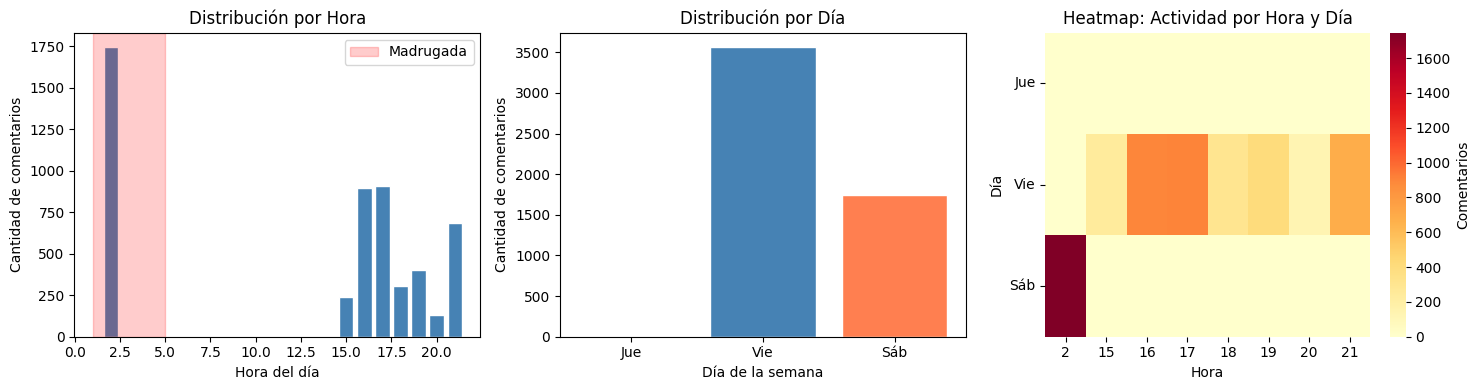

In [12]:
# === VISUALIZACIÓN TEMPORAL ===

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Solo usar datos con timestamps válidos
df_valid = df[valid_time_mask].copy()

if len(df_valid) > 0:
    # 1. Distribución por hora
    hour_counts = df_valid['hour'].value_counts().sort_index()
    axes[0].bar(hour_counts.index, hour_counts.values, color='steelblue', edgecolor='white')
    axes[0].set_xlabel('Hora del día')
    axes[0].set_ylabel('Cantidad de comentarios')
    axes[0].set_title('Distribución por Hora')
    axes[0].axvspan(1, 5, alpha=0.2, color='red', label='Madrugada')
    axes[0].legend()
    
    # 2. Distribución por día de semana
    day_names_full = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
    day_counts = df_valid['day_of_week'].value_counts().sort_index()
    # Usar colores según el día (laboral=azul, finde=coral)
    bar_colors = ['coral' if d >= 5 else 'steelblue' for d in day_counts.index]
    axes[1].bar(day_counts.index, day_counts.values, color=bar_colors, edgecolor='white')
    axes[1].set_xticks(day_counts.index)
    axes[1].set_xticklabels([day_names_full[d] for d in day_counts.index])
    axes[1].set_xlabel('Día de la semana')
    axes[1].set_ylabel('Cantidad de comentarios')
    axes[1].set_title('Distribución por Día')
    
    # 3. Heatmap hora vs día
    heatmap_data = df_valid.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)
    sns.heatmap(heatmap_data, cmap='YlOrRd', ax=axes[2], cbar_kws={'label': 'Comentarios'})
    # Usar solo los días que existen en los datos
    axes[2].set_yticklabels([day_names_full[d] for d in heatmap_data.index], rotation=0)
    axes[2].set_xlabel('Hora')
    axes[2].set_ylabel('Día')
    axes[2].set_title('Heatmap: Actividad por Hora y Día')
else:
    for ax in axes:
        ax.text(0.5, 0.5, 'Sin timestamps válidos', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

## 4. Clasificación de Sentimiento: A FAVOR vs EN CONTRA

Usamos keywords y patrones para clasificar la postura de cada comentario hacia el candidato.

In [13]:
# === CLASIFICACIÓN DE SENTIMIENTO ===

# Keywords positivos/a favor
keywords_favor = [
    'porky presidente', 'mi presidente', 'futuro presidente', 'vamos porky',
    'porky 2026', 'rafael presidente', 'te apoyo', 'mi voto', 'votare por',
    'lo amo', 'el mejor', 'gran lider', 'buen alcalde', 'excelente',
    'dios te bendiga', 'bendiciones', 'te admiro', 'mi cuchisito',
    'visionario', 'genio', 'crack', 'grande', 'adelante', 'arriba',
    'lo mejor', 'confio en', 'esperanza', 'renovacion popular', 'renovación popular'
]

# Keywords negativos/en contra
keywords_contra = [
    'corrupto', 'mentiroso', 'ratero', 'ladron', 'delincuente', 'estafador',
    'payaso', 'loco', 'ridiculo', 'hipocrita', 'farsante', 'basura',
    'nunca votare', 'jamas', 'no votare', 'no lo apoyo', 'peor', 'malo',
    'caviar', 'caviares', 'comunista', 'terrorista', 'fujimori', 'keiko',
    'no sirve', 'fracaso', 'vergüenza', 'verguenza', 'horror', 'terrible',
    'asco', 'inutil', 'incapaz', 'ignorante'
]

def classify_sentiment(text):
    """Clasifica el sentimiento basado en keywords"""
    if not isinstance(text, str):
        return 'neutro'
    
    text_lower = text.lower()
    
    favor_score = sum(1 for kw in keywords_favor if kw in text_lower)
    contra_score = sum(1 for kw in keywords_contra if kw in text_lower)
    
    # Si tiene más keywords a favor
    if favor_score > contra_score and favor_score > 0:
        return 'a_favor'
    # Si tiene más keywords en contra
    elif contra_score > favor_score and contra_score > 0:
        return 'en_contra'
    else:
        return 'neutro'

# Aplicar clasificación
df['sentimiento'] = df['text'].apply(classify_sentiment)

# Crear columnas binarias
df['is_favor'] = (df['sentimiento'] == 'a_favor').astype(int)
df['is_contra'] = (df['sentimiento'] == 'en_contra').astype(int)

print("✅ Clasificación de sentimiento completada")
print(f"\n📊 Distribución de sentimiento:")
print(df['sentimiento'].value_counts())
print(f"\n📈 Porcentajes:")
print(df['sentimiento'].value_counts(normalize=True).mul(100).round(1))

✅ Clasificación de sentimiento completada

📊 Distribución de sentimiento:
sentimiento
neutro       4324
a_favor       789
en_contra     195
Name: count, dtype: int64

📈 Porcentajes:
sentimiento
neutro       81.5
a_favor      14.9
en_contra     3.7
Name: proportion, dtype: float64


🟢 EJEMPLOS A FAVOR:
   1. Mi PRESIDENTE HABLANDO CLARO SR RLA HOMBRE DE BIEN,SENSATO,CULTO,INTELIGENTE,VAL...
   2. FALSO, ahí tiene la izquierda unida con Keikistas , Acuñas pusieron a Jeri en el...
   3. Grande Rafael López Aliaga
   4. Renovación Popular Carabayllo - Oficial- Sumate a la Ola Celeste grande en qué?
   5. Porky Presidente.

🔴 EJEMPLOS EN CONTRA:
   1. Manuelito Ayala Ignorantes de Mier... Lean y sabrán de la realidad peruana
   2. Amanda Ayala Ignorantes de Mier... Lean y sabrán de la realidad peruana
   3. Fue trampa de Gorriti y su organización criminal roja caviar cómplices con la ma...
   4. David Marin Ramos Sanchez mafia roja caviar unidos con mafia china ratera contra...
   5. Los chinos manejan cálidades. Dependiendo cuanto quieras pagar. No todo es malo....


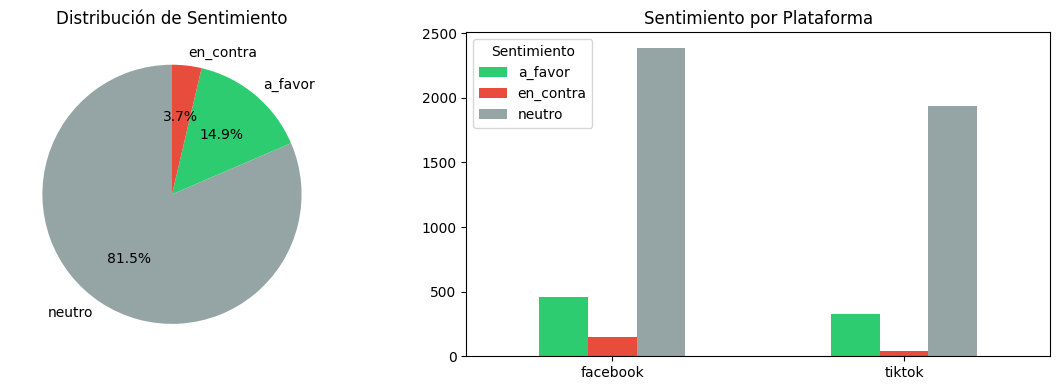

In [14]:
# === MUESTRAS POR SENTIMIENTO ===

print("🟢 EJEMPLOS A FAVOR:")
favor_sample = df[df['sentimiento'] == 'a_favor']['text'].head(5)
for i, text in enumerate(favor_sample, 1):
    print(f"   {i}. {text[:80]}..." if len(str(text)) > 80 else f"   {i}. {text}")

print("\n🔴 EJEMPLOS EN CONTRA:")
contra_sample = df[df['sentimiento'] == 'en_contra']['text'].head(5)
for i, text in enumerate(contra_sample, 1):
    print(f"   {i}. {text[:80]}..." if len(str(text)) > 80 else f"   {i}. {text}")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Pie chart
colors_sent = {'a_favor': '#2ecc71', 'en_contra': '#e74c3c', 'neutro': '#95a5a6'}
sent_counts = df['sentimiento'].value_counts()
axes[0].pie(sent_counts.values, labels=sent_counts.index, autopct='%1.1f%%',
            colors=[colors_sent[s] for s in sent_counts.index], startangle=90)
axes[0].set_title('Distribución de Sentimiento')

# Por plataforma
sent_by_platform = df.groupby(['platform', 'sentimiento']).size().unstack(fill_value=0)
sent_by_platform.plot(kind='bar', ax=axes[1], color=[colors_sent[c] for c in sent_by_platform.columns])
axes[1].set_title('Sentimiento por Plataforma')
axes[1].set_xlabel('')
axes[1].legend(title='Sentimiento')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## 5. Feature Engineering Completo

Creamos todas las features necesarias para la detección:
- Features de texto (ya creadas)
- Features de comportamiento (frecuencia por usuario)
- TF-IDF y similitud entre comentarios
- Features temporales (ya creadas)

In [15]:
# === TF-IDF Y SIMILITUD ===

# Crear vectorizador TF-IDF
tfidf = TfidfVectorizer(
    max_features=500,      # Limitar a 500 features más importantes
    ngram_range=(1, 2),    # Unigramas y bigramas
    min_df=2               # Mínimo 2 documentos
)

# Crear matriz TF-IDF
tfidf_matrix = tfidf.fit_transform(df['text_clean'])

print(f"✅ Matriz TF-IDF creada")
print(f"   Shape: {tfidf_matrix.shape}")
print(f"   Vocabulario: {len(tfidf.get_feature_names_out())} términos")

# Top términos
feature_names = tfidf.get_feature_names_out()
tfidf_sum = np.array(tfidf_matrix.sum(axis=0)).flatten()
top_indices = tfidf_sum.argsort()[-15:][::-1]
print(f"\n📝 Top 15 términos:")
for i in top_indices:
    print(f"   - '{feature_names[i]}': {tfidf_sum[i]:.2f}")

✅ Matriz TF-IDF creada
   Shape: (5308, 500)
   Vocabulario: 500 términos

📝 Top 15 términos:
   - 'presidente': 261.07
   - 'de': 251.31
   - 'porky': 247.14
   - 'que': 213.74
   - 'el': 212.79
   - 'rafael': 205.08
   - 'en': 200.60
   - 'la': 193.84
   - 'no': 177.32
   - 'aliaga': 148.60
   - 'es': 142.99
   - 'lópez': 137.33
   - 'por': 130.19
   - 'lópez aliaga': 126.52
   - 'rafael lópez': 119.66


In [16]:
# === SIMILITUD ENTRE COMENTARIOS ===

print("Calculando matriz de similitud (puede tardar)...")

# Para datasets grandes, calcular similitud por lotes
n = len(df)
batch_size = 1000
avg_similarity = np.zeros(n)
max_similarity = np.zeros(n)

for i in range(0, n, batch_size):
    end_i = min(i + batch_size, n)
    batch_sim = cosine_similarity(tfidf_matrix[i:end_i], tfidf_matrix)
    
    for j in range(end_i - i):
        idx = i + j
        sims = np.concatenate([batch_sim[j, :idx], batch_sim[j, idx+1:]])
        if len(sims) > 0:
            avg_similarity[idx] = sims.mean()
            max_similarity[idx] = sims.max()

df['avg_similarity'] = avg_similarity
df['max_similarity'] = max_similarity

# === FEATURES DE COMPORTAMIENTO POR USUARIO ===

# Frecuencia de comentarios por usuario
user_comment_counts = df['user_id'].value_counts()
df['user_comment_count'] = df['user_id'].map(user_comment_counts).fillna(1)

# Usuarios con muchos comentarios (potencial bot)
df['is_high_frequency_user'] = (df['user_comment_count'] > 5).astype(int)

print("✅ Features de similitud y comportamiento calculadas")
print(f"\n📊 Estadísticas de similitud:")
print(f"   Similitud promedio: {df['avg_similarity'].mean():.4f}")
print(f"   Similitud máxima promedio: {df['max_similarity'].mean():.4f}")

# Comentarios muy similares
high_sim = df[df['max_similarity'] > 0.7]
print(f"\n⚠️ Comentarios con similitud > 0.7: {len(high_sim):,}")

Calculando matriz de similitud (puede tardar)...
✅ Features de similitud y comportamiento calculadas

📊 Estadísticas de similitud:
   Similitud promedio: 0.0320
   Similitud máxima promedio: 0.6862

⚠️ Comentarios con similitud > 0.7: 2,720


## 6. Detección de Anomalías: Isolation Forest + DBSCAN

Aplicamos algoritmos no supervisados para detectar comportamientos anómalos que podrían indicar bots o trolls coordinados.

In [17]:
# === PREPARAR FEATURES PARA MODELOS ===

# Seleccionar features numéricas
feature_columns = [
    # Texto
    'text_length', 'word_count', 'emoji_count', 'exclamation_count',
    'question_count', 'caps_ratio', 'mention_count', 'hashtag_count',
    'is_duplicate', 'is_very_short', 'is_emoji_only',
    # Similitud
    'avg_similarity', 'max_similarity',
    # Comportamiento
    'user_comment_count', 'is_high_frequency_user',
    # Temporal (rellenar NaN con 0)
    'is_late_night', 'is_work_hours', 'is_peak_hours', 'is_weekend'
]

# Crear matriz de features
X = df[feature_columns].fillna(0).values

# Escalar features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✅ Features preparadas para modelos")
print(f"   Shape: {X_scaled.shape}")
print(f"   Features ({len(feature_columns)}): {feature_columns}")

✅ Features preparadas para modelos
   Shape: (5308, 19)
   Features (19): ['text_length', 'word_count', 'emoji_count', 'exclamation_count', 'question_count', 'caps_ratio', 'mention_count', 'hashtag_count', 'is_duplicate', 'is_very_short', 'is_emoji_only', 'avg_similarity', 'max_similarity', 'user_comment_count', 'is_high_frequency_user', 'is_late_night', 'is_work_hours', 'is_peak_hours', 'is_weekend']


In [18]:
# === ISOLATION FOREST ===

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.15,  # Esperamos ~15% de anomalías
    random_state=42,
    n_jobs=-1
)

# Entrenar y predecir (-1 = anomalía, 1 = normal)
df['iso_forest_pred'] = iso_forest.fit_predict(X_scaled)
df['iso_forest_score'] = iso_forest.score_samples(X_scaled)
df['is_anomaly_iforest'] = (df['iso_forest_pred'] == -1).astype(int)

print("✅ Isolation Forest entrenado")
print(f"\n📊 Resultados Isolation Forest:")
print(f"   Anomalías: {df['is_anomaly_iforest'].sum():,} ({df['is_anomaly_iforest'].mean()*100:.1f}%)")
print(f"   Normales: {(df['is_anomaly_iforest'] == 0).sum():,}")

# === DBSCAN ===

dbscan = DBSCAN(
    eps=1.5,
    min_samples=5,
    n_jobs=-1
)

df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)
df['is_anomaly_dbscan'] = (df['dbscan_cluster'] == -1).astype(int)

print(f"\n📊 Resultados DBSCAN:")
print(f"   Clusters: {df['dbscan_cluster'].nunique() - 1}")
print(f"   Outliers: {df['is_anomaly_dbscan'].sum():,} ({df['is_anomaly_dbscan'].mean()*100:.1f}%)")

✅ Isolation Forest entrenado

📊 Resultados Isolation Forest:
   Anomalías: 797 (15.0%)
   Normales: 4,511

📊 Resultados DBSCAN:
   Clusters: 70
   Outliers: 503 (9.5%)


In [19]:
# === DETECCIÓN COMBINADA ===

# Score combinado (0-2)
df['bot_score'] = df['is_anomaly_iforest'] + df['is_anomaly_dbscan']

# Clasificación final
def classify_bot(row):
    if row['bot_score'] == 2:
        return 'Alta sospecha'
    elif row['bot_score'] == 1:
        return 'Sospecha media'
    else:
        return 'Normal'

df['bot_classification'] = df.apply(classify_bot, axis=1)

# === ANÁLISIS POR GRUPO DE SENTIMIENTO ===

print("=" * 60)
print("📊 RESULTADOS FINALES - DETECCIÓN COMBINADA")
print("=" * 60)

print(f"\n🎯 RESUMEN GENERAL:")
print(df['bot_classification'].value_counts())

# Por sentimiento
print(f"\n" + "=" * 60)
print("🟢 ANÁLISIS GRUPO 'A FAVOR'")
print("=" * 60)
favor_df = df[df['sentimiento'] == 'a_favor']
if len(favor_df) > 0:
    print(f"Total comentarios a favor: {len(favor_df):,}")
    print(f"\nDistribución de sospecha:")
    print(favor_df['bot_classification'].value_counts())
    print(f"\nPorcentaje de bots potenciales (alta sospecha): {(favor_df['bot_score'] == 2).mean()*100:.1f}%")

print(f"\n" + "=" * 60)
print("🔴 ANÁLISIS GRUPO 'EN CONTRA'")
print("=" * 60)
contra_df = df[df['sentimiento'] == 'en_contra']
if len(contra_df) > 0:
    print(f"Total comentarios en contra: {len(contra_df):,}")
    print(f"\nDistribución de sospecha:")
    print(contra_df['bot_classification'].value_counts())
    print(f"\nPorcentaje de trolls potenciales (alta sospecha): {(contra_df['bot_score'] == 2).mean()*100:.1f}%")

📊 RESULTADOS FINALES - DETECCIÓN COMBINADA

🎯 RESUMEN GENERAL:
bot_classification
Normal            4325
Sospecha media     666
Alta sospecha      317
Name: count, dtype: int64

🟢 ANÁLISIS GRUPO 'A FAVOR'
Total comentarios a favor: 789

Distribución de sospecha:
bot_classification
Normal            669
Alta sospecha      62
Sospecha media     58
Name: count, dtype: int64

Porcentaje de bots potenciales (alta sospecha): 7.9%

🔴 ANÁLISIS GRUPO 'EN CONTRA'
Total comentarios en contra: 195

Distribución de sospecha:
bot_classification
Normal            170
Sospecha media     14
Alta sospecha      11
Name: count, dtype: int64

Porcentaje de trolls potenciales (alta sospecha): 5.6%


In [20]:
# === EJEMPLOS DE COMENTARIOS SOSPECHOSOS ===

print("🤖 POSIBLES BOTS (A FAVOR - Alta Sospecha):")
print("-" * 50)
bots_favor = df[(df['sentimiento'] == 'a_favor') & (df['bot_score'] == 2)]
for idx, row in bots_favor.head(10).iterrows():
    sim = f"sim:{row['max_similarity']:.2f}"
    dup = "DUP" if row['is_duplicate'] else ""
    platform = row['platform'][:2].upper()
    text = row['text'][:70] + "..." if len(str(row['text'])) > 70 else row['text']
    print(f"   [{platform}] [{sim}] {dup} {text}")

print(f"\n👹 POSIBLES TROLLS (EN CONTRA - Alta Sospecha):")
print("-" * 50)
trolls_contra = df[(df['sentimiento'] == 'en_contra') & (df['bot_score'] == 2)]
for idx, row in trolls_contra.head(10).iterrows():
    sim = f"sim:{row['max_similarity']:.2f}"
    dup = "DUP" if row['is_duplicate'] else ""
    platform = row['platform'][:2].upper()
    text = row['text'][:70] + "..." if len(str(row['text'])) > 70 else row['text']
    print(f"   [{platform}] [{sim}] {dup} {text}")

🤖 POSIBLES BOTS (A FAVOR - Alta Sospecha):
--------------------------------------------------
   [FA] [sim:1.00] DUP RAFAEL PRESIDENTE EN PRIMERA VUELTA!!!
   [FA] [sim:1.00] DUP Excelente
   [FA] [sim:1.00] DUP Es lamentable que medio Lima capital no tenga pistas ni veredas y que ...
   [FA] [sim:0.75]  REAFIRMANDO EL ESPIRITU Y CONSIGNAS RENOVADORAS, SEGUIMOS FRATERNALMEN...
   [FA] [sim:1.00] DUP Sigues perdiendo votos, pones en tu partido a chirinos, a cueto,etc. y...
   [FA] [sim:0.44]  MIS FELICITACIONES EXELENTE INGENIERO RAFAEL LOPEZ ALIAGA POR EL AMOR ...
   [FA] [sim:1.00] DUP Es lamentable que medio Lima capital no tenga pistas ni veredas y que ...
   [FA] [sim:1.00] DUP Sigues perdiendo votos, pones en tu partido a chirinos, a cueto,etc. y...
   [FA] [sim:0.46]  López Aliaga, brillante empresario y gestor, alto intelecto, excelente...
   [FA] [sim:1.00] DUP Porky presidente 2026

👹 POSIBLES TROLLS (EN CONTRA - Alta Sospecha):
------------------------------------------------

## 7. Visualizaciones Finales

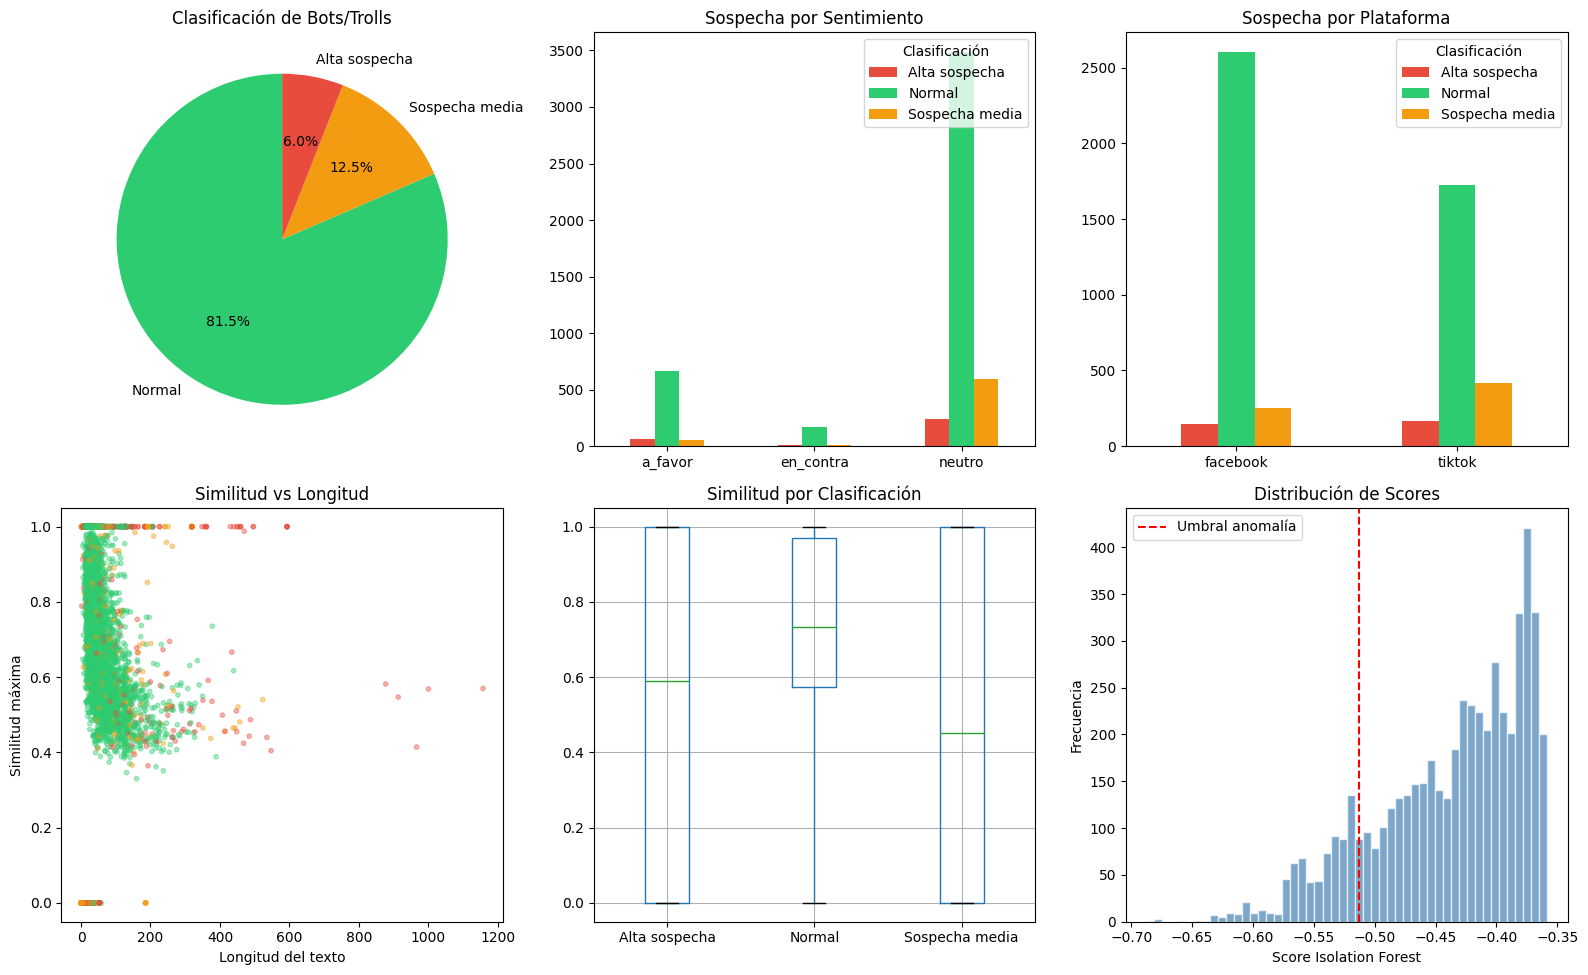

In [21]:
# === VISUALIZACIONES FINALES ===

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Distribución de clasificación de bots
colors_bot = {'Normal': '#2ecc71', 'Sospecha media': '#f39c12', 'Alta sospecha': '#e74c3c'}
bot_counts = df['bot_classification'].value_counts()
axes[0,0].pie(bot_counts.values, labels=bot_counts.index, autopct='%1.1f%%',
              colors=[colors_bot.get(c, 'gray') for c in bot_counts.index], startangle=90)
axes[0,0].set_title('Clasificación de Bots/Trolls')

# 2. Bots por sentimiento
sent_bot = df.groupby(['sentimiento', 'bot_classification']).size().unstack(fill_value=0)
sent_bot.plot(kind='bar', ax=axes[0,1], color=[colors_bot.get(c, 'gray') for c in sent_bot.columns])
axes[0,1].set_title('Sospecha por Sentimiento')
axes[0,1].set_xlabel('')
axes[0,1].legend(title='Clasificación', loc='upper right')
axes[0,1].tick_params(axis='x', rotation=0)

# 3. Bots por plataforma
plat_bot = df.groupby(['platform', 'bot_classification']).size().unstack(fill_value=0)
plat_bot.plot(kind='bar', ax=axes[0,2], color=[colors_bot.get(c, 'gray') for c in plat_bot.columns])
axes[0,2].set_title('Sospecha por Plataforma')
axes[0,2].set_xlabel('')
axes[0,2].legend(title='Clasificación', loc='upper right')
axes[0,2].tick_params(axis='x', rotation=0)

# 4. Scatter: Similitud vs Longitud por sospecha
scatter_colors = df['bot_score'].map({0: '#2ecc71', 1: '#f39c12', 2: '#e74c3c'})
axes[1,0].scatter(df['text_length'], df['max_similarity'], c=scatter_colors, alpha=0.4, s=10)
axes[1,0].set_xlabel('Longitud del texto')
axes[1,0].set_ylabel('Similitud máxima')
axes[1,0].set_title('Similitud vs Longitud')

# 5. Boxplot de similitud por clasificación
df.boxplot(column='max_similarity', by='bot_classification', ax=axes[1,1])
axes[1,1].set_title('Similitud por Clasificación')
axes[1,1].set_xlabel('')
plt.suptitle('')

# 6. Distribución de score de anomalía
axes[1,2].hist(df['iso_forest_score'], bins=50, color='steelblue', edgecolor='white', alpha=0.7)
axes[1,2].axvline(x=df[df['is_anomaly_iforest']==1]['iso_forest_score'].max(), 
                  color='red', linestyle='--', label='Umbral anomalía')
axes[1,2].set_xlabel('Score Isolation Forest')
axes[1,2].set_ylabel('Frecuencia')
axes[1,2].set_title('Distribución de Scores')
axes[1,2].legend()

plt.tight_layout()
plt.show()

## 8. Exportar Resultados

In [22]:
# === EXPORTAR RESULTADOS ===

# Columnas a exportar
export_columns = [
    'platform', 'source_url', 'text', 'username', 'display_name', 'user_id',
    'created_at', 'datetime', 'sentimiento', 'bot_classification', 'bot_score',
    'is_anomaly_iforest', 'is_anomaly_dbscan', 'max_similarity', 'is_duplicate',
    'text_length', 'emoji_count', 'user_comment_count'
]

# Filtrar columnas existentes
export_cols = [c for c in export_columns if c in df.columns]
df_export = df[export_cols].copy()

# Guardar
output_path = '../data/results/analisis_bots_trolls.csv'
df_export.to_csv(output_path, index=False, encoding='utf-8')

print(f"✅ Resultados exportados a: {output_path}")
print(f"\n📊 RESUMEN FINAL:")
print(f"   Total comentarios analizados: {len(df):,}")
print(f"   A favor: {len(df[df['sentimiento']=='a_favor']):,}")
print(f"   En contra: {len(df[df['sentimiento']=='en_contra']):,}")
print(f"   Neutros: {len(df[df['sentimiento']=='neutro']):,}")
print(f"\n   Alta sospecha (bots/trolls): {(df['bot_score']==2).sum():,} ({(df['bot_score']==2).mean()*100:.1f}%)")
print(f"   Sospecha media: {(df['bot_score']==1).sum():,} ({(df['bot_score']==1).mean()*100:.1f}%)")
print(f"   Normal: {(df['bot_score']==0).sum():,} ({(df['bot_score']==0).mean()*100:.1f}%)")

✅ Resultados exportados a: ../data/results/analisis_bots_trolls.csv

📊 RESUMEN FINAL:
   Total comentarios analizados: 5,308
   A favor: 789
   En contra: 195
   Neutros: 4,324

   Alta sospecha (bots/trolls): 317 (6.0%)
   Sospecha media: 666 (12.5%)
   Normal: 4,325 (81.5%)
